## Face Mask Detection
### A face mask detection project is a computer vision application that aims to automatically detect whether a person is wearing a face mask or not in images or real-time video streams.  The project involves the use of machine learning and deep learning techniques to identify and classify individuals into two categories: those wearing masks correctly and those not wearing masks. 

### Let us start the project by importing the necessary ml and deep learning libraries.....

In [130]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import legacy as legacy_optimizers

#### setting the path of the dataset and initialising the parameters

In [131]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C:/Users/ayush/OneDrive/Desktop/Data sc/datasets/Face_Mask_Detection_Dataset_MaskNet'
width=256
height=256
depth=3

#### Converting the image to a numpy array for training the model

In [132]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

#### Creating a link between the folders and appending the image to the list by converting it to array and also adding the labels of the corresponding image to to the label_list

In [133]:
import os
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    
    for folder_name in ["With_mask", "Without_mask"]:
        folder_path = os.path.join(directory_root, folder_name)
        
        if not os.path.exists(folder_path):
            continue  # Skip if the folder doesn't exist
        
        print(f"[INFO] Processing folder: {folder_name} ...")
        
        for image_name in os.listdir(folder_path):
            if image_name.endswith((".jpg", ".JPG",".png")):
                image_directory = os.path.join(folder_path, image_name)
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(folder_name)
    
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error: {e}")


[INFO] Loading images ...
[INFO] Processing folder: With_mask ...
[INFO] Processing folder: Without_mask ...
[INFO] Image loading completed


In [134]:
image_size = len(image_list)
print(image_size)
label_size = len(label_list)
print(label_size)

1290
1290


#### Performing label binarization i.e saving the label binarizer to a file, and determining the number of classes in your dataset
#### label binarizer converts the categorical values to label

In [135]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [136]:
print(label_binarizer.classes_)

['With_mask' 'Without_mask']


#### converting the elements of array in range 0-1 which will increase accuracy

In [137]:
np_image_list = np.array(image_list, dtype=np.float16) / 223.0

In [138]:
print(" Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

 Spliting data to train, test


In [139]:
'''# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)'''
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)
print(y_train.shape)
print(y_test.shape)

(1032,)
(258,)


In [140]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [141]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Dense(1, activation="sigmoid"))

In [142]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_75 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_66 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 85, 85, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 85, 85, 32)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 85, 85, 64)      

In [143]:
opt = Adam(lr=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [144]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1032, 256, 256, 3)
(258, 256, 256, 3)
(1032,)
(258,)


In [145]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1)

Epoch 1/25
32/32 [==============================] - 132s 4s/step - loss: 0.0787 - accuracy: 0.9760 - val_loss: 18.6580 - val_accuracy: 0.4612
Epoch 2/25
32/32 [==============================] - 127s 4s/step - loss: 0.0234 - accuracy: 0.9970 - val_loss: 11.4978 - val_accuracy: 0.4612
Epoch 3/25
32/32 [==============================] - 124s 4s/step - loss: 0.0246 - accuracy: 0.9950 - val_loss: 5.9953 - val_accuracy: 0.4612
Epoch 4/25
32/32 [==============================] - 116s 4s/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 4.5209 - val_accuracy: 0.4612
Epoch 5/25
32/32 [==============================] - 127s 4s/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 6.0261 - val_accuracy: 0.4612
Epoch 6/25
32/32 [==============================] - 147s 5s/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 3.9814 - val_accuracy: 0.4612
Epoch 7/25
32/32 [==============================] - 143s 4s/step - loss: 0.0171 - accuracy: 0.9970 - val_loss: 4.8871 - val_accuracy: 0.4612
Epoch 8/25


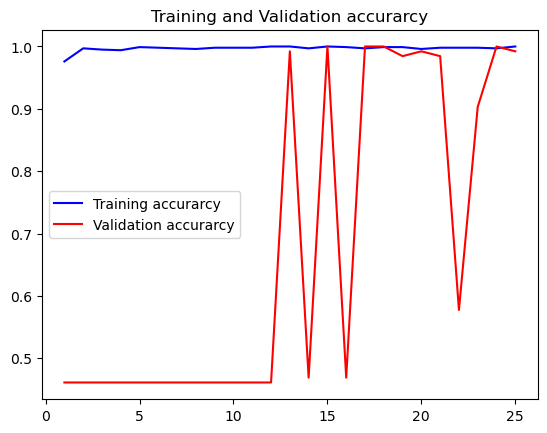

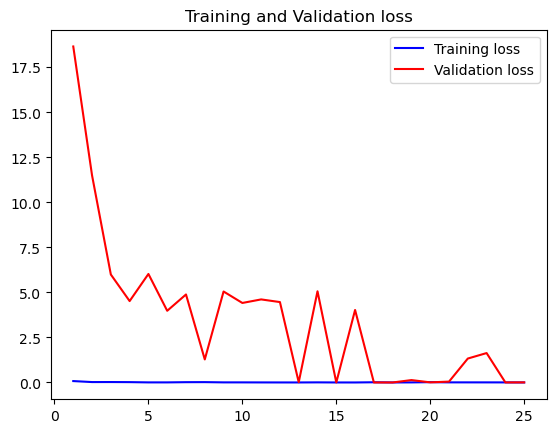

In [148]:
acc = history.history['accuracy']  # 'accuracy' for training accuracy
val_acc = history.history['val_accuracy']  # 'val_accuracy' for validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [149]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('face_model.pkl', 'wb'))

[INFO] Saving model...


In [150]:
# Assuming you have trained your model and have test_data and test_labels
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Display the total accuracy
print(f'Total Accuracy: {test_accuracy * 100:.2f}%')

9/9 [==============================] - 6s 602ms/step - loss: 0.0058 - accuracy: 0.9922
Total Accuracy: 99.22%


In [156]:
from tensorflow.keras.preprocessing.image import load_img
# Load the image
image_path = "C:/Users/ayush/OneDrive/Desktop/Data sc/datasets/Face_Mask_Detection_Dataset_MaskNet/With_Mask/B001.jpg"

image = load_img(image_path, target_size=(height, width))  # Adjust target_size as per your model's input size

# Convert the image to a NumPy array
image_array = img_to_array(image)

# Normalize pixel values if needed (e.g., dividing by 223.0 for values in [0, 1])
image_array /= 223.0

# Expand dimensions to match the input shape of your model
image_array = np.expand_dims(image_array, axis=0)

In [157]:
# Make predictions
predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions)
predicted_class = label_list[predicted_class_index]
print(f"Predicted type: {predicted_class}")

1/1 [==============================] - 0s 81ms/step
Predicted type: With_mask
